#### Advanced Statistics for Data Science (Spring 2022)
# Home Assignment 6
#### Topics:
- Multiple Regression
- Model/Variable Selection

#### Due: 07/06/2022 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below. 
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>
<hr>


**Name**: Ofir Nesher

**Student ID**:

**Date**: 25/05/2022

$
\newcommand{\Id}{{\mathbf{I}}}  
\newcommand{\SSE}{\mathsf{SSE}}
\newcommand{\SSR}{\mathsf{SSR}}
\newcommand{\MSE}{\mathsf{MSE}}
\newcommand{\simiid}{\overset{iid}{\sim}}
\newcommand{\ex}{\mathbb E}
\newcommand{\var}{\mathrm{Var}}
\newcommand{\Cov}[2]{{\mathrm{Cov}  \left(#1, #2 \right)}}
\newcommand{\one}[1]{\mathbf 1 {\left\{#1\right\}}}
\newcommand{\SE}[1]{\mathrm{SE} \left[#1\right]}
\newcommand{\reals}{\mathbb R}
\newcommand{\Ncal}{\mathcal N}
\newcommand{\abs}[1]{\ensuremath{\left\vert#1\right\vert}}
\newcommand{\rank}{\operatorname{rank}}
\newcommand{\tr}{\operatorname{Tr}}
\newcommand{\diag}{\operatorname{diag}}
\newcommand{\sign}{\operatorname{sign}}
$


<hr>
<hr>

## Problem 1 (Multiple Regression)

Use the house prices dataset from class. Load it using the function ``load_house_prices_data``. We will use ``LogSalePrice`` as the target variable (note that this is a transformed version of the original sale price)

1. Use all variables in the data returned by ``load_house_prices_data``. Find at least one pair of competing predictors.
2. A construction company is trying to figure out how to design a new development for maximal profit. They propose that since ``SecondFlrSF`` (second floor square footage, proportional to second floor square meter) is correlated with ``SalePrice``, they should try and maximize second floor area in their designs. Does this conclusion make sense considering that ``SecondFlrSF`` is correlated with``TotRmsAbvGrd``? offer a procedure that checks the effect of ``SecondFlrSF`` on ``SalePrice`` and gives more information to make such decision.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def load_house_prices_data(path="../../datasets/housing_prices.csv"):
    """
    Args:
    -----
    path:  path to csv file
    
    Load and clean house prices data:
        filters for numeric predictors only
        filters for small lots only
        renames varaibles so that all variable names begins with [a-z]
        applies a variance stabilizing transformation to SalePrice
        removes outliers
    """

    def detect_outliers(df, q=0.01):
        lower_outliers = df < df.quantile(q)
        upper_outliers = df > df.quantile(1 - q)
        return lower_outliers | upper_outliers

    data_raw = pd.read_csv(path)
    data1 = data_raw[data_raw.LotArea < 15000]  # focus on small lots
    data1 = data1.select_dtypes('number').dropna()
    data1 = data1.rename(  # stats model formula cannot have
        # covaraite names starting with non letter
        columns={'1stFlrSF': 'FirstFlrSF',
                 '2ndFlrSF': 'SecondFlrSF'})

    variables = [
        'SalePrice',
        'LotArea',
        'YearBuilt',
        'YrSold', 'MoSold',
        'Fireplaces',
        'GarageCars', 'ScreenPorch',
        'HalfBath', 'FullBath',
        'GrLivArea',
        'BedroomAbvGr',
        'FirstFlrSF',
        'SecondFlrSF',
        'TotRmsAbvGrd',
        'LowQualFinSF', 'TotalBsmtSF',
        'LotFrontage', 'WoodDeckSF',
        'OverallQual',
        'OverallCond'
    ]

    data1 = data1.filter(variables).dropna()
    data1['LogSalePrice'] = np.log(1 + data1['SalePrice'])
    data1 = data1.drop('SalePrice', axis=1)

    mask = detect_outliers(data1, .01).any(1)
    print(f"Masked a fraction of {mask.mean()} of the data due to outliers")
    return data1[~mask]

### **Answers**:

#### 1.

In [16]:
data = load_house_prices_data()
data.head()

Masked a fraction of 0.14971209213051823 of the data due to outliers


,LotArea,YearBuilt,YrSold,MoSold,Fireplaces,GarageCars,ScreenPorch,HalfBath,FullBath,GrLivArea,...,FirstFlrSF,SecondFlrSF,TotRmsAbvGrd,LowQualFinSF,TotalBsmtSF,LotFrontage,WoodDeckSF,OverallQual,OverallCond,LogSalePrice
0,8450,2003,2008,2,0,2,0,1,2,1710,...,856,854,8,0,856,65.0,0,7,5,12.247699
1,9600,1976,2007,5,1,2,0,0,2,1262,...,1262,0,6,0,1262,80.0,298,6,8,12.109016
2,11250,2001,2008,9,1,2,0,1,2,1786,...,920,866,6,0,920,68.0,0,7,5,12.317171
3,9550,1915,2006,2,1,3,0,0,1,1717,...,961,756,7,0,756,60.0,0,7,5,11.849405
4,14260,2000,2008,12,1,3,0,1,2,2198,...,1145,1053,9,0,1145,84.0,192,8,5,12.429220


In [17]:
data.corr()

,LotArea,YearBuilt,YrSold,MoSold,Fireplaces,GarageCars,ScreenPorch,HalfBath,FullBath,GrLivArea,...,FirstFlrSF,SecondFlrSF,TotRmsAbvGrd,LowQualFinSF,TotalBsmtSF,LotFrontage,WoodDeckSF,OverallQual,OverallCond,LogSalePrice
LotArea,1.000000,0.090393,-0.031381,0.031132,0.227209,0.240321,0.065470,0.069411,0.096400,0.327647,...,0.342480,0.050232,0.351833,-0.126916,0.262895,0.719806,0.152168,0.166403,-0.055529,0.355051
YearBuilt,0.090393,1.000000,0.021733,0.028505,0.114062,0.587519,-0.067284,0.213962,0.594095,0.294528,...,0.340449,0.016873,0.156066,0.061923,0.449177,0.115866,0.243981,0.636197,-0.453766,0.677513
YrSold,-0.031381,0.021733,1.000000,-0.157243,-0.030237,-0.041381,0.035544,-0.002167,0.013284,-0.024518,...,-0.008110,-0.016845,-0.052060,-0.077227,0.001961,-0.008179,0.036433,-0.001552,-0.003149,-0.013812
MoSold,0.031132,0.028505,-0.157243,1.000000,0.056809,0.082095,-0.029429,-0.018937,0.086807,0.106836,...,0.062458,0.055672,0.049638,-0.014338,0.047506,0.073365,0.081131,0.107993,-0.024367,0.110740
Fireplaces,0.227209,0.114062,-0.030237,0.056809,1.000000,0.222265,0.140024,0.167719,0.227471,0.446801,...,0.325798,0.180768,0.331482,-0.053318,0.258285,0.187161,0.159201,0.380178,-0.072207,0.424475
GarageCars,0.240321,0.587519,-0.041381,0.082095,0.222265,1.000000,-0.007460,0.163308,0.543130,0.480209,...,0.429470,0.129593,0.370608,0.016144,0.432215,0.270508,0.184149,0.573772,-0.316951,0.647935
ScreenPorch,0.065470,-0.067284,0.035544,-0.029429,0.140024,-0.007460,1.000000,0.029367,-0.033443,0.067728,...,0.082138,0.001124,0.031682,-0.015144,0.062171,0.035526,-0.086232,0.024508,0.073189,0.070674
HalfBath,0.069411,0.213962,-0.002167,-0.018937,0.167719,0.163308,0.029367,1.000000,0.117993,0.438772,...,-0.293852,0.669987,0.338726,0.078671,-0.175986,0.018690,0.064616,0.220941,-0.084609,0.277943
FullBath,0.096400,0.594095,0.013284,0.086807,0.227471,0.543130,-0.033443,0.117993,1.000000,0.610555,...,0.341531,0.329032,0.474251,0.049221,0.315989,0.101816,0.212468,0.589743,-0.337131,0.612454
GrLivArea,0.327647,0.294528,-0.024518,0.106836,0.446801,0.480209,0.067728,0.438772,0.610555,1.000000,...,0.393322,0.673915,0.795648,-0.035945,0.313491,0.283401,0.208902,0.578776,-0.206741,0.693484


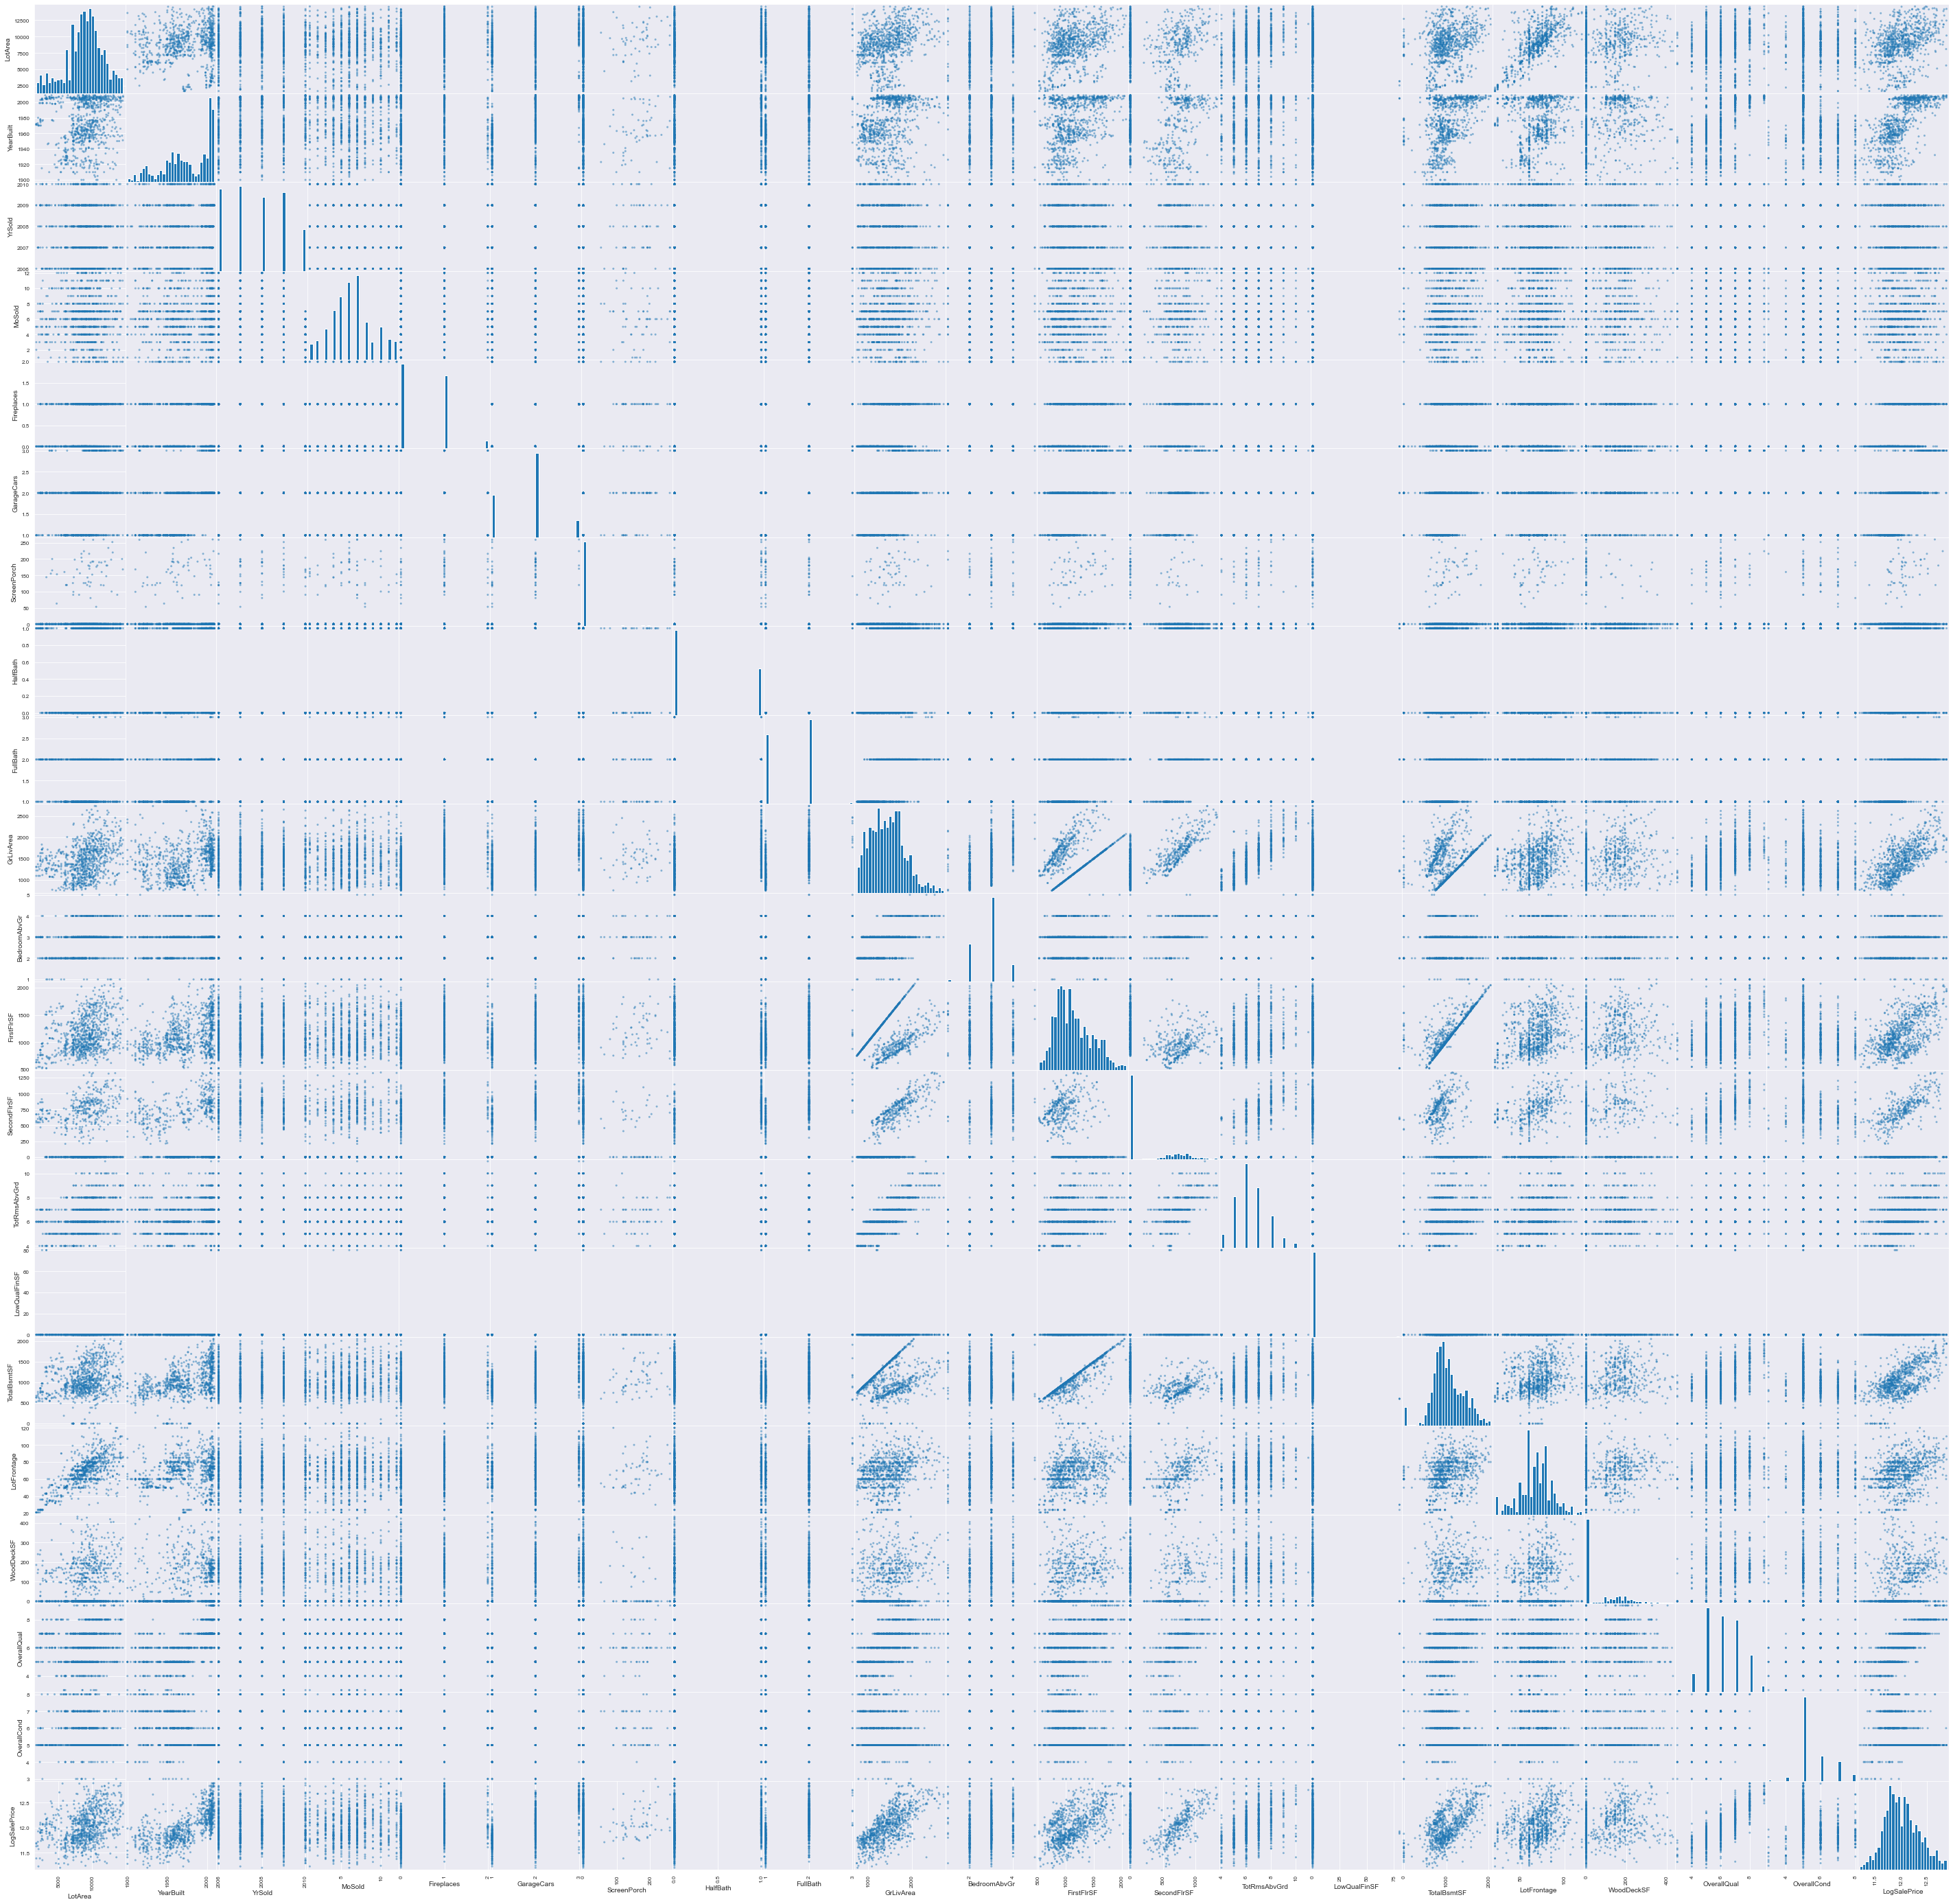

In [18]:
pd.plotting.scatter_matrix(data, hist_kwds={'bins': 30}, figsize=(50, 50))
plt.show()

We see that LotArea & GrLivArea have a positive correlation (0.32). So let's see their p-value:

In [19]:
from scipy.stats import pearsonr

r, p = pearsonr(data['LotArea'], data['GrLivArea'])

It is significant, so we can say that these are 2 competing predictors.

#### 2. Partial Correlation
As seen in class & lecture 9's notebook:
We want to ask whether `SecondFlrSF` affects positively on `LogSalePrice`.
However, what if `SecondFlrSF` is merely a function of the number of rooms which responsible to the increase?
In this case, adding `SecondFlrSF` would not affect the price (because we did not change the number of rooms).
To account for the effect of `SecondFlrSF` on `LogSalePrice`, we can adjust for the number of rooms.

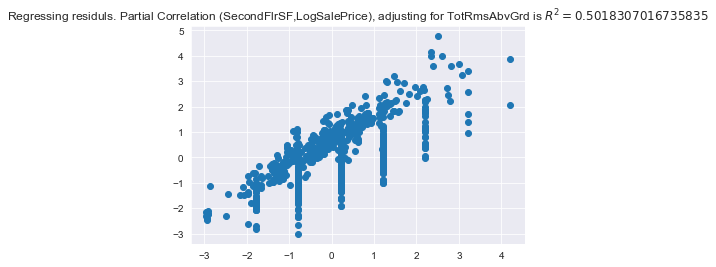

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

varX = 'SecondFlrSF'
varY = 'LogSalePrice'
varZ = 'TotRmsAbvGrd'  # total rooms above ground level

model_1 = smf.ols(formula=f"{varZ} ~ {varX}", data=data).fit()
model_2 = smf.ols(formula=f"{varZ} ~ {varY}", data=data).fit()

X = sm.add_constant(model_1.resid)
y = model_2.resid
model_res = sm.OLS(y, X).fit()

plt.scatter(model_1.resid, model_2.resid)
plt.title(
    fr"Regressing residuals. Partial Correlation ({varX},{varY}), adjusting for {varZ} is $R^2 = {model_res.rsquared}$")
plt.show()

In [21]:
model_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.501    
Dependent Variable: y                AIC:                2146.0621
Date:               2022-06-07 22:55 BIC:                2155.6355
No. Observations:   886              Log-Likelihood:     -1071.0  
Df Model:           1                F-statistic:        890.5    
Df Residuals:       884              Prob (F-statistic): 6.58e-136
R-squared:          0.502            Scale:              0.65840  
---------------------------------------------------------------------
         Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
---------------------------------------------------------------------
const    0.0000      0.0273     0.0000    1.0000    -0.0535    0.0535
0        0.7561      0.0253    29.8412    0.0000     0.7064    0.8058
------------------------------------------------------------------
Omnibus:               4.600        Durbin-Watson:           2.117
Prob(Omnibus):         0.100        Jarque-Bera (JB):        3.586
Skew:                  0.013        Prob(JB):                0.166
Kurtosis:              2.689        Condition No.:           1    
==================================================================

"""

In [22]:
pearsonr(model_1.resid, model_2.resid)

(0.7084000999954639, 6.58329139619998e-136)

We see that the partial correlation, which is the correlation between the 2 sets of residuals adjusted to `TotRmsAbvGrd`, is positive with a significant p-value.

This means that `TotRmsAbvGrd` is correlated with both `SecondFlrSF` AND `LogSalePrice`, so increasing `SecondFlrSF` will not increase `LogSalePrice`, and the company's proposition does not make sense!

---

## Problem 2 (Variable Selection)

Use the house prices dataset from class. Load it using the function ``load_house_prices_data``. 

1. Write the function ``backward_select`` (prototype below). Apply it on the house prices dataset and report the resulting model. 
2. Write a function that receives as an input a set of predictors and the response and evaluates the leave-one-out accuracy (n-fold cross validation). What is the CV-error of the model you found in 1 ?
3. Consider the predictors ``OverallCond``, ``YearBuilt``, ``LotArea``, ``Fireplaces``. Go over all $2^4$ models. Evaluate $R^2$, AIC, BIC, and leave-one-out CV-error for every model and print the results. Report on the model with the lowest AIC, BIC, CV-error.

Hint: for 1, modify the ``forward_select`` function from class.

### **Answers**:

In [23]:
from scipy.stats import f as ftest

response = 'LogSalePrice'
data = load_house_prices_data()

Masked a fraction of 0.14971209213051823 of the data due to outliers


#### 1.

In [24]:
def backward_select(data, response, sig_level=.05):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data: pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    sig_level:  significance level for F-test

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept selected by backward selection
           evaluated by R-squared and F-test for extra sum of squares
    """
    remaining = [c for c in data.columns if not c == response]

    n = len(data)
    varst = ' + '.join(remaining)
    formula = f"{response} ~ {varst} + 1"
    fitted = smf.ols(formula, data).fit()
    SS_prev = fitted.ssr
    Ftest_pval = np.inf
    itr = 0

    while remaining and Ftest_pval > sig_level:
        itr += 1
        R2_without_candidates = []
        SS_without_candidates = {}

        for candidate in remaining:
            temp_remaining = remaining.copy()
            temp_remaining.remove(candidate)

            varst = ' + '.join(temp_remaining)
            formula = f"{response} ~ {varst} + 1"
            fitted = smf.ols(formula, data).fit()
            R2 = fitted.rsquared
            SS_candidate = fitted.ssr
            R2_without_candidates.append((R2, candidate))
            SS_without_candidates[candidate] = SS_candidate

        R2_without_candidates.sort()
        best_new_R2, best_candidate = R2_without_candidates.pop()
        SS_new = SS_without_candidates[best_candidate]
        f = (SS_new - SS_prev) / (SS_new / (n - len(remaining) + 1))
        Ftest_pval = ftest.sf(f, dfn=1, dfd=(n - len(remaining) + 1))
        SS_prev = SS_new

        print(f"=========  Step {itr} ==========")
        print(f"Best Candidate = {best_candidate}")
        print(f"Best R2 = {best_new_R2}")
        print(f"Ftest = {Ftest_pval}")
        print("=============================")

        if Ftest_pval > sig_level:
            remaining.remove(best_candidate)
        else:
            print(f"We do not remove {best_candidate}")

    formula = f"{response} ~ {' + '.join(remaining)} + 1"
    model = smf.ols(formula, data).fit()

    return model, remaining

    # option 2:
    # inspired by https://www.datasklr.com/ols-least-squares-regression/variable-selection
    # included = [c for c in data.columns if c != response]
    #
    # while len(included) > 0:
    #     changed = False
    #     model = sm.OLS(y, sm.add_constant(data[included])).fit()
    #     # use all coefficients except intercept
    #     pvalues = model.pvalues.iloc[1:]
    #     worst_pval = pvalues.max()  # null if pvalues is empty
    #
    #     if worst_pval > sig_level:
    #         changed = True
    #         worst_feature = pvalues.idxmax()
    #         included.remove(worst_feature)
    #
    #         if verbose:
    #             print(f'Drop {worst_feature} with p-value {worst_pval}')
    #
    #     if not changed:
    #         break
    #
    # return included

In [25]:
model, backward_selected_predictors = backward_select(data, response, sig_level=.05)
backward_selected_predictors

=========  Step 1 ==========
Best Candidate = SecondFlrSF
Best R2 = 0.8813367852737968
Ftest = 0.9999997525260467
=========  Step 2 ==========
Best Candidate = FirstFlrSF
Best R2 = 0.8813367839222539
Ftest = 0.9974919800619522
=========  Step 3 ==========
Best Candidate = FullBath
Best R2 = 0.8813350395146318
Ftest = 0.9100372289485714
=========  Step 4 ==========
Best Candidate = YrSold
Best R2 = 0.8812921022753188
Ftest = 0.5749648629380304
=========  Step 5 ==========
Best Candidate = TotRmsAbvGrd
Best R2 = 0.881228316291594
Ftest = 0.49419770764343285
=========  Step 6 ==========
Best Candidate = LowQualFinSF
Best R2 = 0.8811416099859131
Ftest = 0.42533734930136624
=========  Step 7 ==========
Best Candidate = MoSold
Best R2 = 0.8808095534727463
Ftest = 0.11923454163135486
=========  Step 8 ==========
Best Candidate = LotFrontage
Best R2 = 0.8801924897242571
Ftest = 0.03414592677184731
We do not remove LotFrontage


['LotArea',
 'YearBuilt',
 'Fireplaces',
 'GarageCars',
 'ScreenPorch',
 'HalfBath',
 'GrLivArea',
 'BedroomAbvGr',
 'TotalBsmtSF',
 'LotFrontage',
 'WoodDeckSF',
 'OverallQual',
 'OverallCond']

#### 2.

In [26]:
def leave_one_out_cross_validation(data, predictors, response):
    """"shortcut" version from lecture 10 notes"""
    intercept = np.ones(len(data))
    Z = np.column_stack([intercept, data[predictors].values])
    y = data[response].values

    H = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    y_hat = H @ y  # "Puts the hat on y"
    residuals_hat = y - y_hat
    errors = np.square(residuals_hat) / np.square(1 - H)

    return errors.mean()


leave_one_out_cross_validation(data, backward_selected_predictors, response)

0.01323426527816888

---

## Problem 3 (Selecting Order of Regression using Cross-Validation)

Consider the dataset ``AnneFrank.csv``, describing the number of searches of the term "Anne Frank" by hour over several days in February 2022. The cell below contains code you should use to arrange the data by hours.

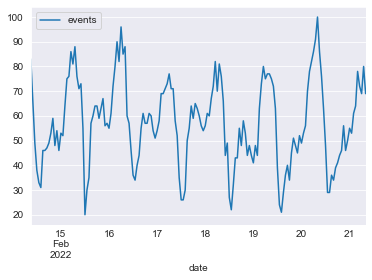

In [27]:
AnneFrank = pd.read_csv("../../datasets/AnneFrank.csv", header=1, names=['time', 'events'])
AnneFrank['date'] = pd.to_datetime(AnneFrank.time)
# AnneFrank['time'] = AnneFrank['date'].astype(int) / 3600000000000
# AnneFrank['time'] = AnneFrank['time'] - AnneFrank['time'].min()
AnneFrank.plot(x='date', y='events')
plt.xticks(rotation='vertical')
plt.show()

In this question you will fit a model to the response based on $2p+1$ predictors of the form:
$$
\begin{align}
x_1 = [1,~\ldots~,1]
\end{align}
$$
$$
\begin{align}
x_{2k} & = \sin(2 \pi \cdot k \cdot t / 60) \\
x_{2k+1} & = \cos(2 \pi \cdot k \cdot t / 60), \qquad k=1,\ldots,p-1.
\end{align}
$$
(these are sinusoids of increasing frequency at a resolution of 1min) You will then use the selected model to predict the number of events in future times.

1. Write a function ``generate_Z`` that receives as inputs a vector of time indices (representing hours) ``t`` and ``p``. The function returns the design matrix $Z$ of size $n \times (2p+1)$, where $n$ is the length of ``t``.
2. For each $p=1,\ldots,20$, fit a linear model to ``events`` based on $Z$ you obtain from ``generate_Z`` and evaluate its leave-one-out CV error. Plot the CV error versus $p$.
3. Report on the model with the lowest CV error; plot its response over time along with the original response in the figure above. 
4. Using the model you found in 3, predict the number of event at times $t=168.\ldots,190$. Plot your prediction over time in the same figure as above, i.e., interpolate the response curve to future value. 
5. For each $t$ in 4, construct a 0.95 confidence interval of your prediction. Plot the upper and lower limits of this interval over time (these lines define a confidence band). Here, you may ignore the danger of inference based on the t distribution after applying a model selection procedure. 

Hints: (2) In order to evaluate the CV error, you'll need the hat matrix (which you can get directly from Z) and the residuals in the LS fit (which you can get from the ``resid`` property of the fitted model object returned by ``statsmodels.api.OLS.fit``). (4) you can use the function ``predict`` of the fitted model object by passing new predictors that you generate using ``generate_Z``. For 5, $s^2$ is given by the property ``mse_resid`` (or ``ssr`` divided by the number of degrees of freedom). Also note that the number of degrees of freedom is $2p+1$ where $p$ is the number you found in 3.

### **Answers**:

#### 1.

In [28]:
def generate_Z(t, p):
    """
    Args:
    ----
    t:   vector of time samples (length n)
    p:   number of frequencies (overall 2p+1 predictors)

    Returns:
    --------
    Z:  design matrix of size (n, 2p+1)
    """
    n = len(t)
    tt = np.arange(0, n)
    x1 = np.ones(n)
    aaa = [x1]

    for k in range(1, p + 1):
        k1 = np.sin(2 * np.pi * k * tt / 60)
        k2 = np.cos(2 * np.pi * k * tt / 60)
        aaa.append(k1)
        aaa.append(k2)

    Z = np.column_stack(aaa)

    return Z

In [29]:
# Z = generate_Z(AnneFrank['date'], 5)

#### 2.

In [30]:
# response
y = AnneFrank['events']
CV_errors = {}

for p in range(1, 21):
    Z = generate_Z(AnneFrank['date'], p)
    H = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    y_hat = H @ y
    results = sm.OLS(y, y_hat).fit()
    residuals = results.resid
    CV_errors[p] = residuals.mean()

CV_errors

{1: -1.5310504187211682e-14,
 2: 7.443781041296288e-15,
 3: 6.597896832058073e-15,
 4: -2.0808751547260076e-14,
 5: 1.048896419455386e-14,
 6: -1.0996494720096789e-14,
 7: 7.105427357601002e-15,
 8: -2.6391587328232294e-14,
 9: 1.9286159970631292e-14,
 10: 5.752012622819859e-15,
 11: 2.3177227333127077e-14,
 12: -3.4173722053223865e-14,
 13: -3.214359995105215e-15,
 14: 6.767073673905716e-16,
 15: -1.0319787352706217e-14,
 16: 2.266969680758415e-14,
 17: 8.458842092382145e-15,
 18: 3.434289889507151e-14,
 19: 2.1992989440193578e-14,
 20: 1.3872501031506718e-14}

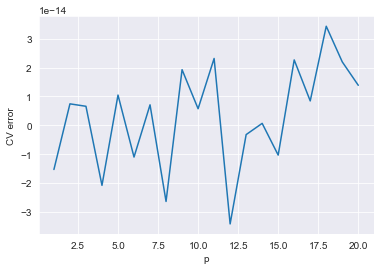

In [31]:
lists = sorted(CV_errors.items())  # sorted by key, return a list of tuples
x_axis, y_axis = zip(*lists)  # unpack a list of pairs into two tuples
plt.plot(x_axis, y_axis)
plt.xlabel('p')
plt.ylabel('CV error')
plt.show()

#### 3.

minimal p == 12


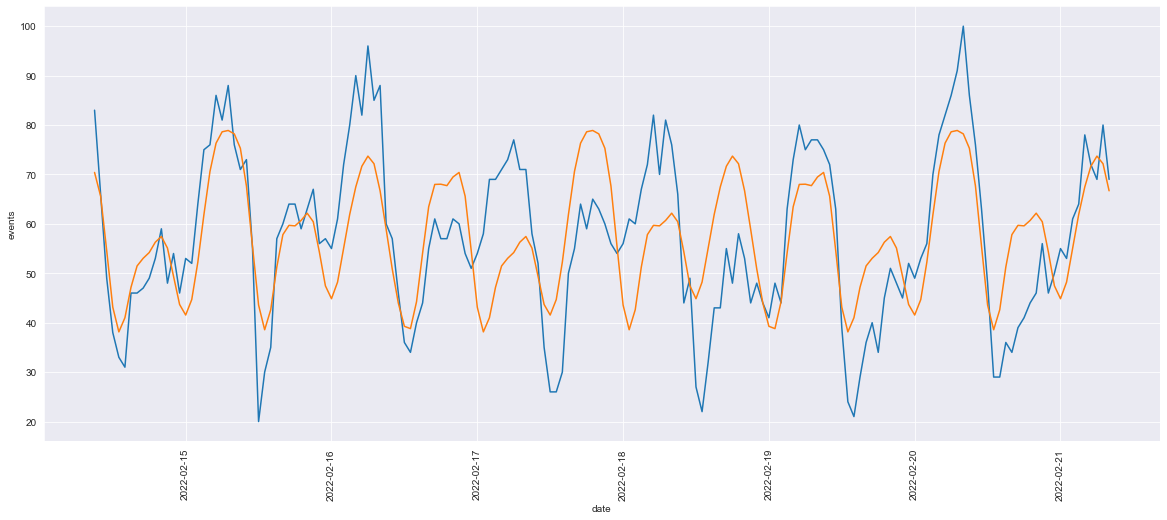

In [32]:
min_p = min(CV_errors, key=CV_errors.get)
print(f'minimal p == {min_p}')

Z = generate_Z(AnneFrank['date'], min_p)
H = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
y_hat = H @ y

plt.figure(figsize=(20, 8))
plt.plot(AnneFrank['date'].values, y)
plt.plot(AnneFrank['date'].values, y_hat)
plt.xlabel('date')
plt.ylabel('events')
plt.xticks(rotation='vertical')
plt.show()

#### 4.

In [33]:
model = sm.OLS(y, generate_Z(AnneFrank['date'], min_p))
results = model.fit()

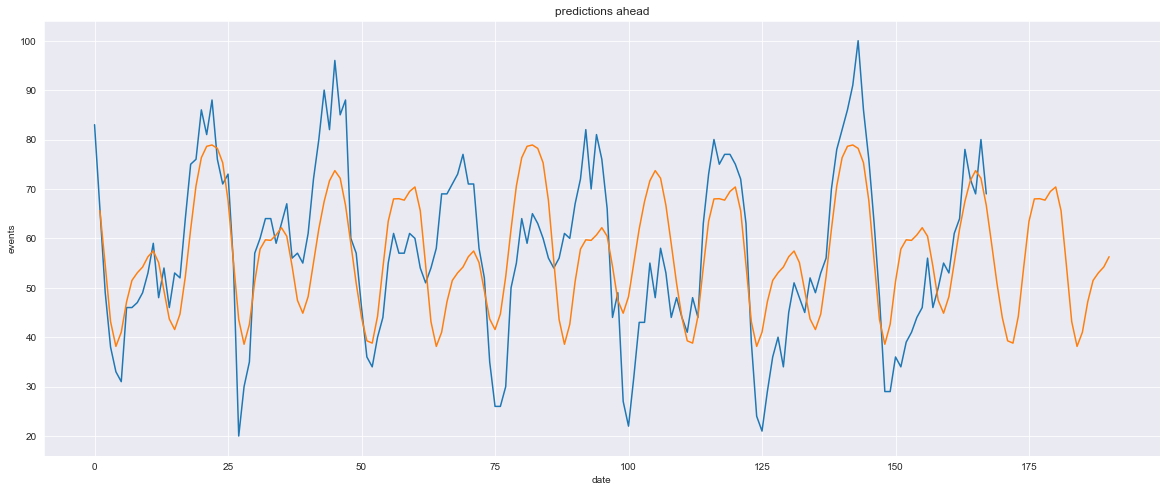

In [34]:
ttn = np.arange(1, 191)
x1 = np.ones(len(ttn))
aaa = [x1]

for k in range(1, min_p + 1):
    k1 = np.sin(2 * np.pi * k * ttn / 60)
    k2 = np.cos(2 * np.pi * k * ttn / 60)
    aaa.append(k1)
    aaa.append(k2)

Z_new = np.column_stack(aaa)
y_new = model.predict(results.params, Z_new)

n = len(y)
tt = np.arange(0, n)

plt.figure(figsize=(20, 8))
plt.plot(tt, y)
plt.plot(ttn, y_new)
plt.title("predictions ahead")
plt.xlabel('date')
plt.ylabel('events')
plt.show()